In [36]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, LSTM, GRU, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from datetime import datetime
import dateutil.relativedelta

In [37]:
np.random.seed(42)
tf.random.set_seed(42)

In [38]:
df = pd.read_csv('/Users/suryatejachalla/Projects/Solar-Data-Analysis/Data/processed/sunspot.csv')
df['date'] = pd.to_datetime(df[['year', 'month']].assign(day=1))
df = df.sort_values('date')

df.head()

,ssn,year,month,date
0,135.9,1749,7,1749-07-01
1,137.9,1749,8,1749-08-01
2,140.2,1749,9,1749-09-01
3,143.8,1749,10,1749-10-01
4,146.4,1749,11,1749-11-01


In [39]:
train_end = pd.to_datetime('2019-12-01')  # End of cycle 24
validation_end = pd.to_datetime('2024-07-01')  # Current data end

In [40]:
train_data = df[df['date'] <= train_end]
validation_data = df[(df['date'] > train_end) & (df['date'] <= validation_end)]

# Create a copy of the validation dates for later use in plotting
validation_dates = validation_data['date'].reset_index(drop=True)

In [41]:
last_date = validation_dates.iloc[-1]
forecast_months = (2030 - last_date.year) * 12 + (12 - last_date.month) + 1
future_dates = [last_date + dateutil.relativedelta.relativedelta(months=i) for i in range(1, forecast_months)]
future_dates = pd.Series(future_dates)

In [42]:
scaler = MinMaxScaler(feature_range=(0, 1))
train_scaled = scaler.fit_transform(train_data[['ssn']])
validation_scaled = scaler.transform(validation_data[['ssn']])

In [43]:
def create_sequences(data, window_size):
    X, y = [], []
    for i in range(len(data) - window_size):
        X.append(data[i:(i + window_size), 0])
        y.append(data[i + window_size, 0])
    return np.array(X), np.array(y)

In [45]:
window_size = 60
X_train, y_train = create_sequences(train_scaled, window_size)
X_val, y_val = create_sequences(validation_scaled, window_size)

In [46]:
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], 1)
X_val = X_val.reshape(X_val.shape[0], X_val.shape[1], 1)

IndexError: tuple index out of range

In [47]:
model = Sequential()
model.add(LSTM(60, return_sequences=True, input_shape=(window_size, 1), activation='tanh'))
# model.add(LSTM(10, activation='tanh'))
model.add(Dense(1, activation='relu'))

model.compile(optimizer='adam', loss='mse')

early_stop = EarlyStopping(monitor='val_loss', patience=10, restore_best_weights=True)

model.summary()

/opt/anaconda3/envs/ssn/lib/python3.11/site-packages/keras/src/layers/rnn/rnn.py:200: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_5 (LSTM)                   │ (None, 60, 60)         │        14,880 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_3 (Dense)                 │ (None, 60, 1)          │            61 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 14,941 (58.36 KB)

 Trainable params: 14,941 (58.36 KB)

 Non-trainable params: 0 (0.00 B)

In [48]:
history = model.fit(
    X_train, y_train,
    epochs=100,
    batch_size=16,
    validation_data=(X_val, y_val),
    callbacks=[early_stop],
    verbose=1
)

Epoch 1/100


200/200 ━━━━━━━━━━━━━━━━━━━━ 0s 6ms/step - loss: 0.0643

ValueError: Exception encountered when calling Sequential.call().

[1mInvalid input shape for input Tensor("data:0", shape=(16,), dtype=float32). Expected shape (None, 60, 1), but input has incompatible shape (16,)[0m

Arguments received by Sequential.call():
  • inputs=tf.Tensor(shape=(16,), dtype=float32)
  • training=False
  • mask=None

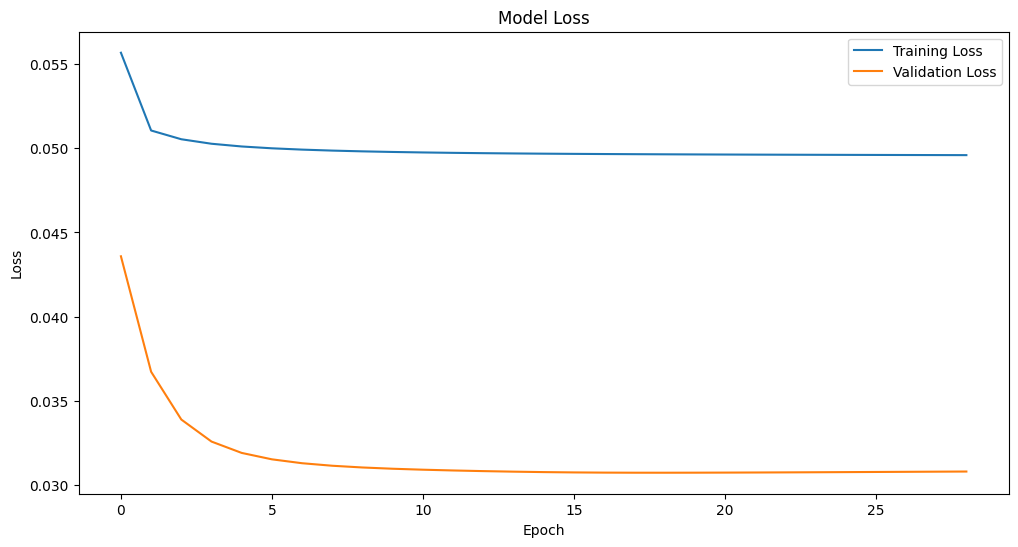

In [33]:
plt.figure(figsize=(12, 6))
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Model Loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend()
plt.show()

In [34]:
val_predictions = []
# Start with the first window from validation data
current_batch = X_val[0].reshape(1, window_size, 1)

# For each point in validation range
for i in range(len(validation_data) - window_size):
    # Predict next value
    current_pred = model.predict(current_batch, verbose=0)[0][0]
    val_predictions.append(current_pred)
    
    # Update the batch to include the new prediction (fix the dimension issue)
    # First, remove the oldest value
    current_batch = current_batch[:, 1:, :]
    # Then add the new prediction with correct shape [1, 1, 1]
    current_batch = np.concatenate([current_batch, 
                                   np.array([[[current_pred]]])], axis=1)

ValueError: all the input arrays must have same number of dimensions, but the array at index 0 has 3 dimension(s) and the array at index 1 has 4 dimension(s)

ValueError: x and y must have same first dimension, but have shapes (19,) and (1, 1)

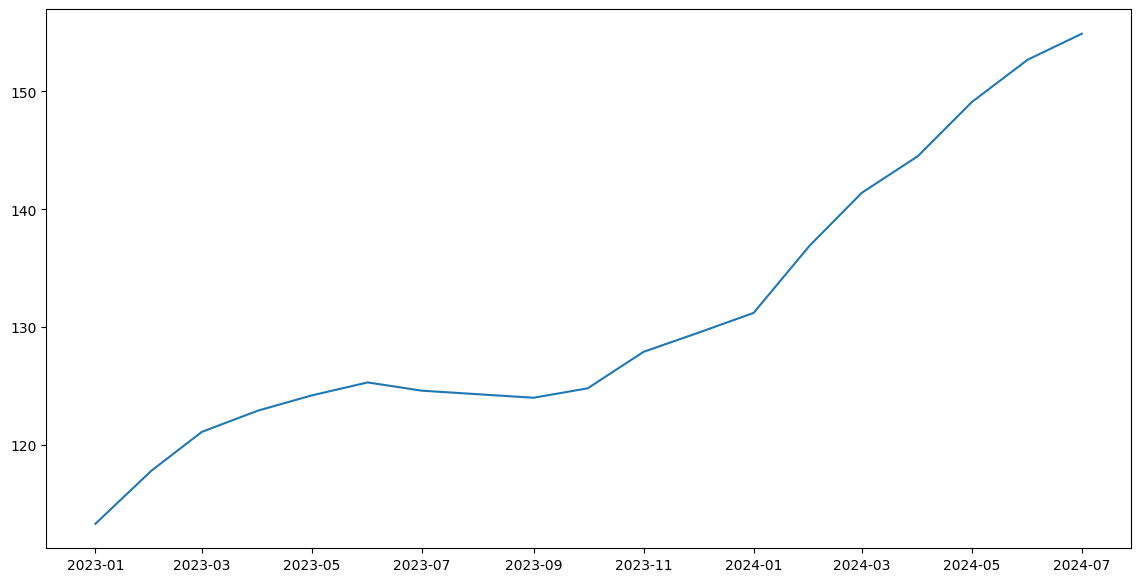

In [35]:
# Inverse scaling to get actual values
val_predictions = scaler.inverse_transform(np.array(val_predictions).reshape(-1, 1))

# Prepare actual values for validation period (excluding first window_size values since we can't predict them)
actual_values = validation_data['ssn'].values[window_size:]

# Plot the validation results
plt.figure(figsize=(14, 7))
plt.plot(validation_dates[window_size:], actual_values, label='Actual SSN')
plt.plot(validation_dates[window_size:], val_predictions, label='Predicted SSN')
plt.title('Validation: Actual vs Predicted Sunspot Numbers (Cycle 25 Beginning)')
plt.xlabel('Date')
plt.ylabel('Sunspot Number (SSN)')
plt.legend()
plt.grid(True)
plt.show()

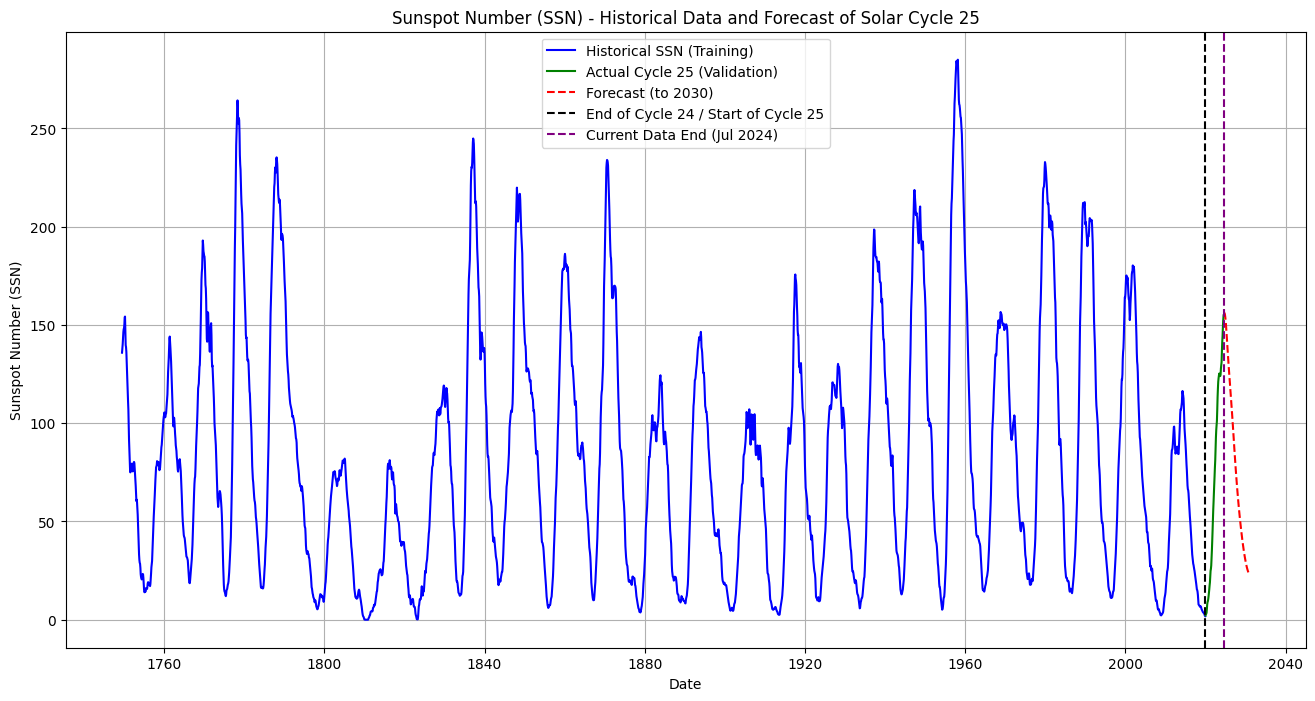

In [30]:
future_predictions = []
# Start with the last window from validation data
last_window = validation_scaled[-window_size:].reshape(1, window_size, 1)
current_batch = last_window.copy()

# Forecast up to December 2030
for _ in range(len(future_dates)):
    # Predict next value
    next_pred = model.predict(current_batch, verbose=0)[0][0]
    future_predictions.append(next_pred)
    
    # Update the batch with fixed dimensionality
    current_batch = current_batch[:, 1:, :]
    current_batch = np.concatenate([current_batch, 
                                   np.array([[[next_pred]]])], axis=1)

# Inverse scaling to get actual values
future_predictions = scaler.inverse_transform(np.array(future_predictions).reshape(-1, 1))

# Combine all data for final visualization
plt.figure(figsize=(16, 8))

# Historical data (cycles 1-24)
plt.plot(train_data['date'], train_data['ssn'], label='Historical SSN (Training)', color='blue')

# Cycle 25 validation period
plt.plot(validation_dates, validation_data['ssn'], label='Actual Cycle 25 (Validation)', color='green')

# Future predictions
plt.plot(future_dates, future_predictions, label='Forecast (to 2030)', color='red', linestyle='--')

# Add vertical lines to mark cycle transitions
plt.axvline(x=train_end, color='k', linestyle='--', label='End of Cycle 24 / Start of Cycle 25')
plt.axvline(x=validation_end, color='purple', linestyle='--', label='Current Data End (Jul 2024)')

plt.title('Sunspot Number (SSN) - Historical Data and Forecast of Solar Cycle 25')
plt.xlabel('Date')
plt.ylabel('Sunspot Number (SSN)')
plt.legend()
plt.grid(True)
plt.show()

In [19]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

rmse = np.sqrt(mean_squared_error(actual_values, val_predictions))
mae = mean_absolute_error(actual_values, val_predictions)

print(f"Validation RMSE: {rmse:.2f}")
print(f"Validation MAE: {mae:.2f}")

# Additionally, let's identify the predicted peak of Cycle 25
peak_idx = np.argmax(future_predictions)
peak_date = future_dates[peak_idx]
peak_value = future_predictions[peak_idx][0]

print(f"Predicted Cycle 25 Peak: {peak_value:.1f} occurring around {peak_date.strftime('%B %Y')}")

Validation RMSE: 10.97
Validation MAE: 8.89
Predicted Cycle 25 Peak: 160.0 occurring around December 2024
